## 0.0 Import Packages

In [1]:
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_columns', 50)
import pickle
import seaborn as sns
sns.set(color_codes=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.0 Loading Data

In [2]:
PICKLE_TRAIN_DIR = os.path.join("..", "processed_data", "train_data.pkl")
PICKLE_HISTORY_DIR = os.path.join("..", "processed_data", "history_data.pkl")

In [3]:
history_data = pd.read_pickle(PICKLE_HISTORY_DIR)
train = pd.read_pickle(PICKLE_TRAIN_DIR)

## 2.0 Feature Engineering

In [4]:
mean_year = history_data.groupby(["id"]).mean().reset_index()
mean_6m = history_data[history_data["price_date"] > "2015-06-01"].groupby(["id"]).mean().reset_index()
mean_3m = history_data[history_data["price_date"] > "2015-10-01"].groupby(["id"]).mean().reset_index()

In [5]:
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var",
 "price_p2_var": "mean_year_price_p2_var",
"price_p3_var": "mean_year_price_p3_var",
"price_p1_fix": "mean_year_price_p1_fix",
"price_p2_fix": "mean_year_price_p2_fix",
"price_p3_fix": "mean_year_price_p3_fix",})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

In [6]:
mean_6m = mean_6m.rename(index=str, columns={"price_p1_var": "mean_6m_price_p1_var",
 "price_p2_var": "mean_6m_price_p2_var",
"price_p3_var": "mean_6m_price_p3_var",
"price_p1_fix": "mean_6m_price_p1_fix",
"price_p2_fix": "mean_6m_price_p2_fix",
"price_p3_fix": "mean_6m_price_p3_fix",})
mean_6m["mean_6m_price_p1"] = mean_6m["mean_6m_price_p1_var"] + mean_6m["mean_6m_price_p1_fix"]
mean_6m["mean_6m_price_p2"] = mean_6m["mean_6m_price_p2_var"] + mean_6m["mean_6m_price_p2_fix"]
mean_6m["mean_6m_price_p3"] = mean_6m["mean_6m_price_p3_var"] + mean_6m["mean_6m_price_p3_fix"]

In [7]:
mean_3m = mean_3m.rename(index=str, columns={"price_p1_var": "mean_3m_price_p1_var",
 "price_p2_var": "mean_3m_price_p2_var",
"price_p3_var": "mean_3m_price_p3_var",
"price_p1_fix": "mean_3m_price_p1_fix",
"price_p2_fix": "mean_3m_price_p2_fix",
"price_p3_fix": "mean_3m_price_p3_fix",})
mean_3m["mean_3m_price_p1"] = mean_3m["mean_3m_price_p1_var"] + mean_3m["mean_3m_price_p1_fix"]
mean_3m["mean_3m_price_p2"] = mean_3m["mean_3m_price_p2_var"] + mean_3m["mean_3m_price_p2_fix"]
mean_3m["mean_3m_price_p3"] = mean_3m["mean_3m_price_p3_var"] + mean_3m["mean_3m_price_p3_fix"]

In [8]:
features = mean_year

In [9]:
train["tenure"] = ((train["date_end"]-train["date_activ"])/ np.timedelta64(1, "Y")).astype(int)

In [10]:
tenure = train[["tenure", "churn", "id"]].groupby(["tenure", "churn"])["id"].count().unstack(level=1)
tenure_percentage = (tenure.div(tenure.sum(axis=1), axis=0)*100)

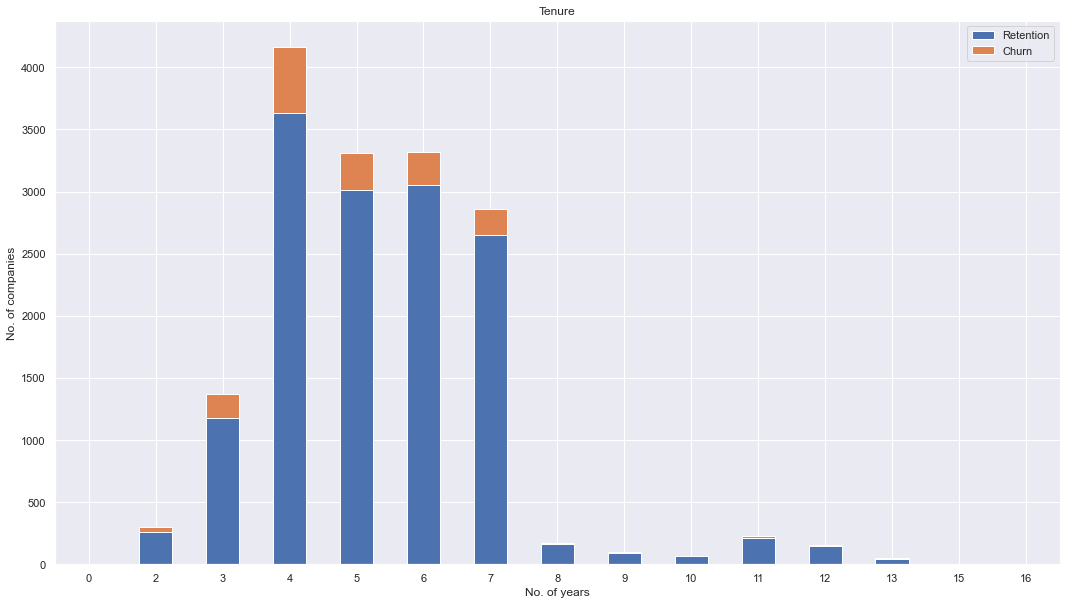

In [11]:
tenure.plot(kind="bar",
 figsize=(18,10),
 stacked=True,
rot=0,
 title= "Tenure")
# Rename legend
plt.legend(["Retention", "Churn"], loc="upper right")
# Labels
plt.ylabel("No. of companies")
plt.xlabel("No. of years")
plt.show()

In [12]:
def convert_months(reference_date, dataframe, column):
 """
 Input a column with timedeltas and return months
 """
 time_delta = REFERENCE_DATE - dataframe[column]
 months = (time_delta / np.timedelta64(1, "M")).astype(int)
 return months

In [13]:
REFERENCE_DATE = datetime.datetime(2016,1,1)

In [14]:
train["months_activ"] = convert_months(REFERENCE_DATE, train, "date_activ")
train["months_to_end"] = -convert_months(REFERENCE_DATE, train, "date_end")
train["months_modif_prod"] = convert_months(REFERENCE_DATE, train, "date_modif_prod")
train["months_renewal"] = convert_months(REFERENCE_DATE, train, "date_renewal")

In [15]:
def plot_churn_by_month(dataframe, column, fontsize_=11):
 """
 Plot churn distribution by monthly variable
 """
 temp = dataframe[[column, "churn", "id"]].groupby([column, "churn"])["id"].count().unstack(level=1)
 temp.plot(kind="bar",
 figsize=(18,10),
 stacked=True,
 rot=0,
 title= column)
 # Rename legend
 plt.legend(["Retention", "Churn"], loc="upper right")
 # Labels
 plt.ylabel("No. of companies")
 plt.xlabel("No. of months")
 # Set xlabel fontsize
 plt.xticks(fontsize=fontsize_)
 plt.show()

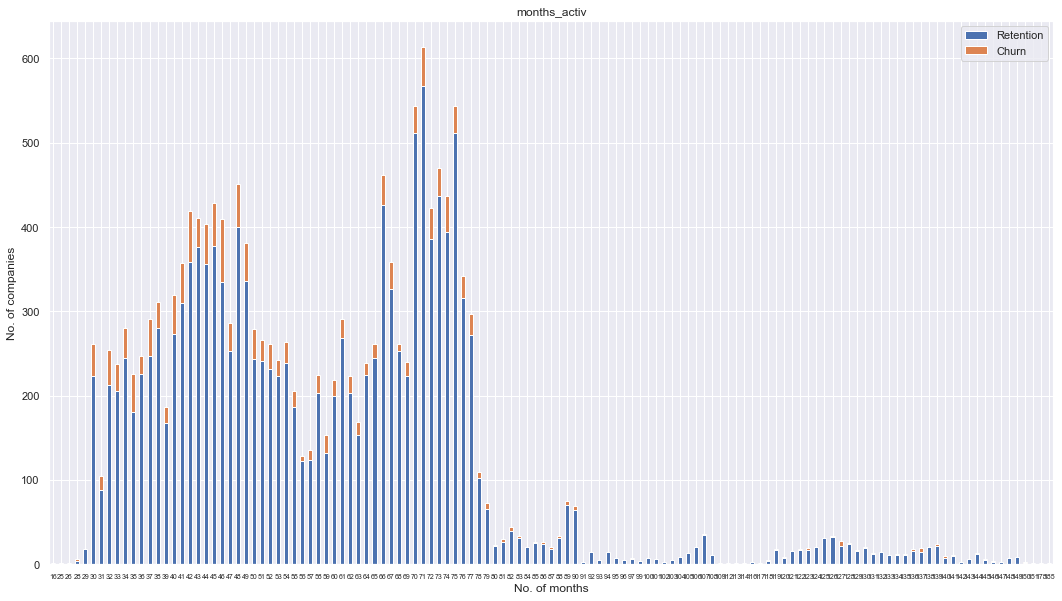

In [16]:
plot_churn_by_month(train, "months_activ", 7)

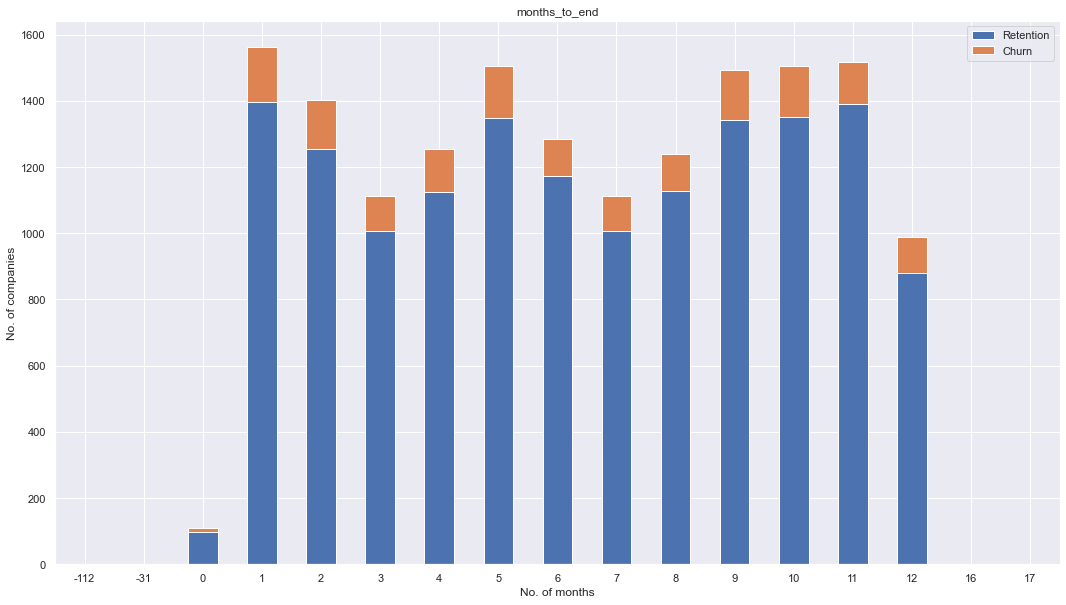

In [17]:
plot_churn_by_month(train, "months_to_end")

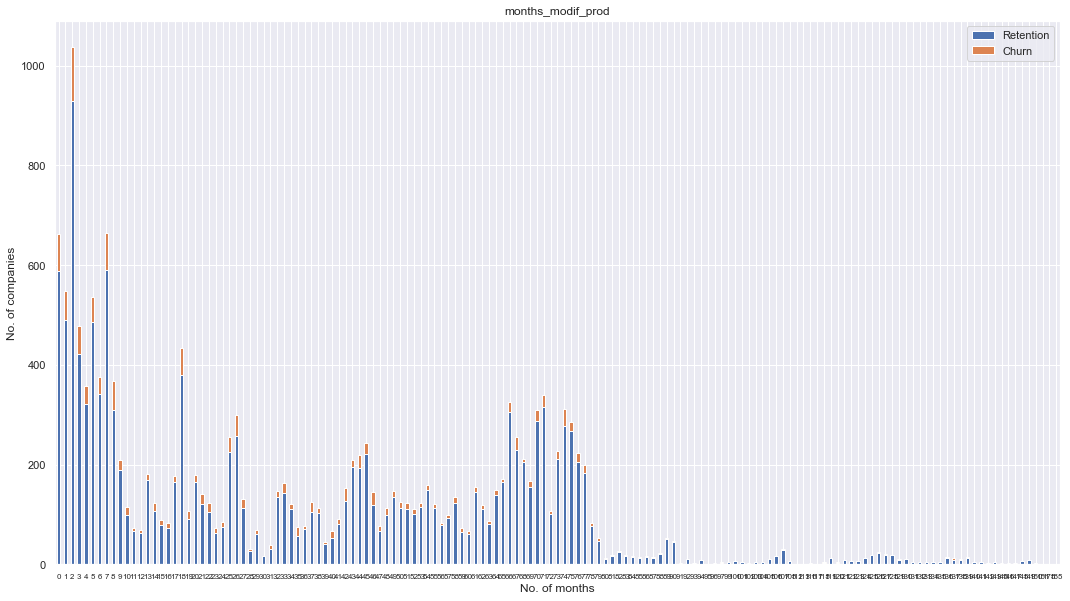

In [18]:
plot_churn_by_month(train, "months_modif_prod", 8)

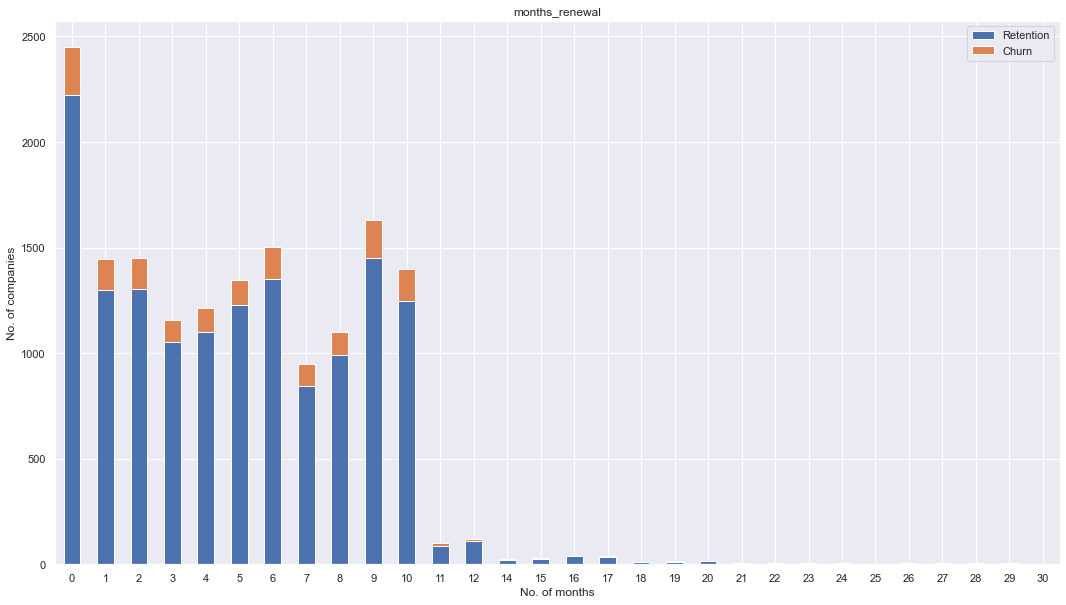

In [19]:
plot_churn_by_month(train, "months_renewal")

Remove the date columns

In [20]:
train.drop(columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"],inplace=True)

### 2.1 Transforming boolean data

In [21]:
train["has_gas"]=train["has_gas"].replace(["t", "f"],[1,0])

### 2.2 Categorical data and dummy variables

In [22]:
train["channel_sales"] = train["channel_sales"].fillna("null_values_channel")

In [23]:
# Transform to categorical data type
train["channel_sales"] = train["channel_sales"].astype("category")

In [24]:
pd.DataFrame({"Samples in category": train["channel_sales"].value_counts()})

,Samples in category
foosdfpfkusacimwkcsosbicdxkicaua,7377
null_values_channel,4218
lmkebamcaaclubfxadlmueccxoimlema,2073
usilxuppasemubllopkaafesmlibmsdf,1444
ewpakwlliwisiwduibdlfmalxowmwpci,966
sddiedcslfslkckwlfkdpoeeailfpeds,12
epumfxlbckeskwekxbiuasklxalciiuu,4
fixdbufsefwooaasfcxdxadsiekoceaa,2


In [25]:
categories_channel = pd.get_dummies(train["channel_sales"], prefix = "channel")

In [26]:
categories_channel.columns = [col_name[:11] for col_name in categories_channel.columns]

In [27]:
categories_channel.head(5)

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_nul,channel_sdd,channel_usi
0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0


In [28]:
categories_channel.drop(columns=["channel_nul"],inplace=True)

In [29]:
train["origin_up"] = train["origin_up"].fillna("null_values_origin")

In [30]:
train["origin_up"] = train["origin_up"].astype("category")

In [31]:
pd.DataFrame({"Samples in category": train["origin_up"].value_counts()})

,Samples in category
lxidpiddsbxsbosboudacockeimpuepw,7825
kamkkxfxxuwbdslkwifmmcsiusiuosws,4517
ldkssxwpmemidmecebumciepifcamkci,3664
null_values_origin,87
usapbepcfoloekilkwsdiboslwaxobdp,2
ewxeelcelemmiwuafmddpobolfuxioce,1


In [32]:
# Create dummy variables
categories_origin = pd.get_dummies(train["origin_up"], prefix = "origin")
# Rename columns for simplicity
categories_origin.columns = [col_name[:10] for col_name in categories_origin.columns]

In [33]:
categories_origin.head(5)

,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_nul,origin_usa
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [34]:
categories_origin.drop(columns=["origin_nul"],inplace=True)

### 2.3 Categorical Data - Feature Engineering

In [35]:
train["activity_new"] = train["activity_new"].fillna("null_values_activity")

In [36]:
categories_activity = pd.DataFrame({"Activity samples":train["activity_new"].value_counts()})
categories_activity

,Activity samples
null_values_activity,9545
apdekpcbwosbxepsfxclislboipuxpop,1577
kkklcdamwfafdcfwofuscwfwadblfmce,422
kwuslieomapmswolewpobpplkaooaaew,230
fmwdwsxillemwbbwelxsampiuwwpcdcb,219
...,...
iilxdefdkwudppkiekwlcexkdupeucla,1
kllldxcildwkssbmoabmsdffmawsafsf,1
wkwdccuiboaeaalcaawlwmldiwmpewma,1
ksukukiwxdxwbfwaapmuwippflemumlp,1


In [37]:
# Get the categories with less than 75 samples
to_replace = list(categories_activity[categories_activity["Activity samples"] <= 75].index)
# Replace them with `null_values_categories`
train["activity_new"]=train["activity_new"].replace(to_replace,"null_values_activity")

In [38]:
# Create dummy variables
categories_activity = pd.get_dummies(train["activity_new"], prefix = "activity")
# Rename columns for simplicity
categories_activity.columns = [col_name[:12] for col_name in categories_activity.columns]

In [39]:
categories_activity.head(5)

,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_sfi,activity_wxe
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,1,0,0


In [40]:
# Use common index to merge
train = pd.merge(train, categories_channel, left_index=True, right_index=True)
train = pd.merge(train, categories_origin, left_index=True, right_index=True)
train = pd.merge(train, categories_activity, left_index=True, right_index=True)

In [41]:
train.drop(columns=["channel_sales", "origin_up", "activity_new"],inplace=True)

In [42]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_sfi,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,0.184145,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,35.741240,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.808648,0.005157,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,0.387615,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,30.609746,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.393378,0.071626,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,0.000000,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,0.000000,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,29.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,0.000000,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,64.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,17537

In [43]:
# Remove negative values
train.loc[train.cons_12m < 0,"cons_12m"] = np.nan
train.loc[train.cons_gas_12m < 0,"cons_gas_12m"] = np.nan
train.loc[train.cons_last_month < 0,"cons_last_month"] = np.nan
train.loc[train.forecast_cons_12m < 0,"forecast_cons_12m"] = np.nan
train.loc[train.forecast_cons_year < 0,"forecast_cons_year"] = np.nan
train.loc[train.forecast_meter_rent_12m < 0,"forecast_meter_rent_12m"] = np.nan
train.loc[train.imp_cons < 0,"imp_cons"] = np.nan

In [44]:
# Apply log10 transformation
train["cons_12m"] = np.log10(train["cons_12m"]+1)
train["cons_gas_12m"] = np.log10(train["cons_gas_12m"]+1)
train["cons_last_month"] = np.log10(train["cons_last_month"]+1)
train["forecast_cons_12m"] = np.log10(train["forecast_cons_12m"]+1)
train["forecast_cons_year"] = np.log10(train["forecast_cons_year"]+1)
train["forecast_meter_rent_12m"] = np.log10(train["forecast_meter_rent_12m"]+1)
train["imp_cons"] = np.log10(train["imp_cons"]+1)

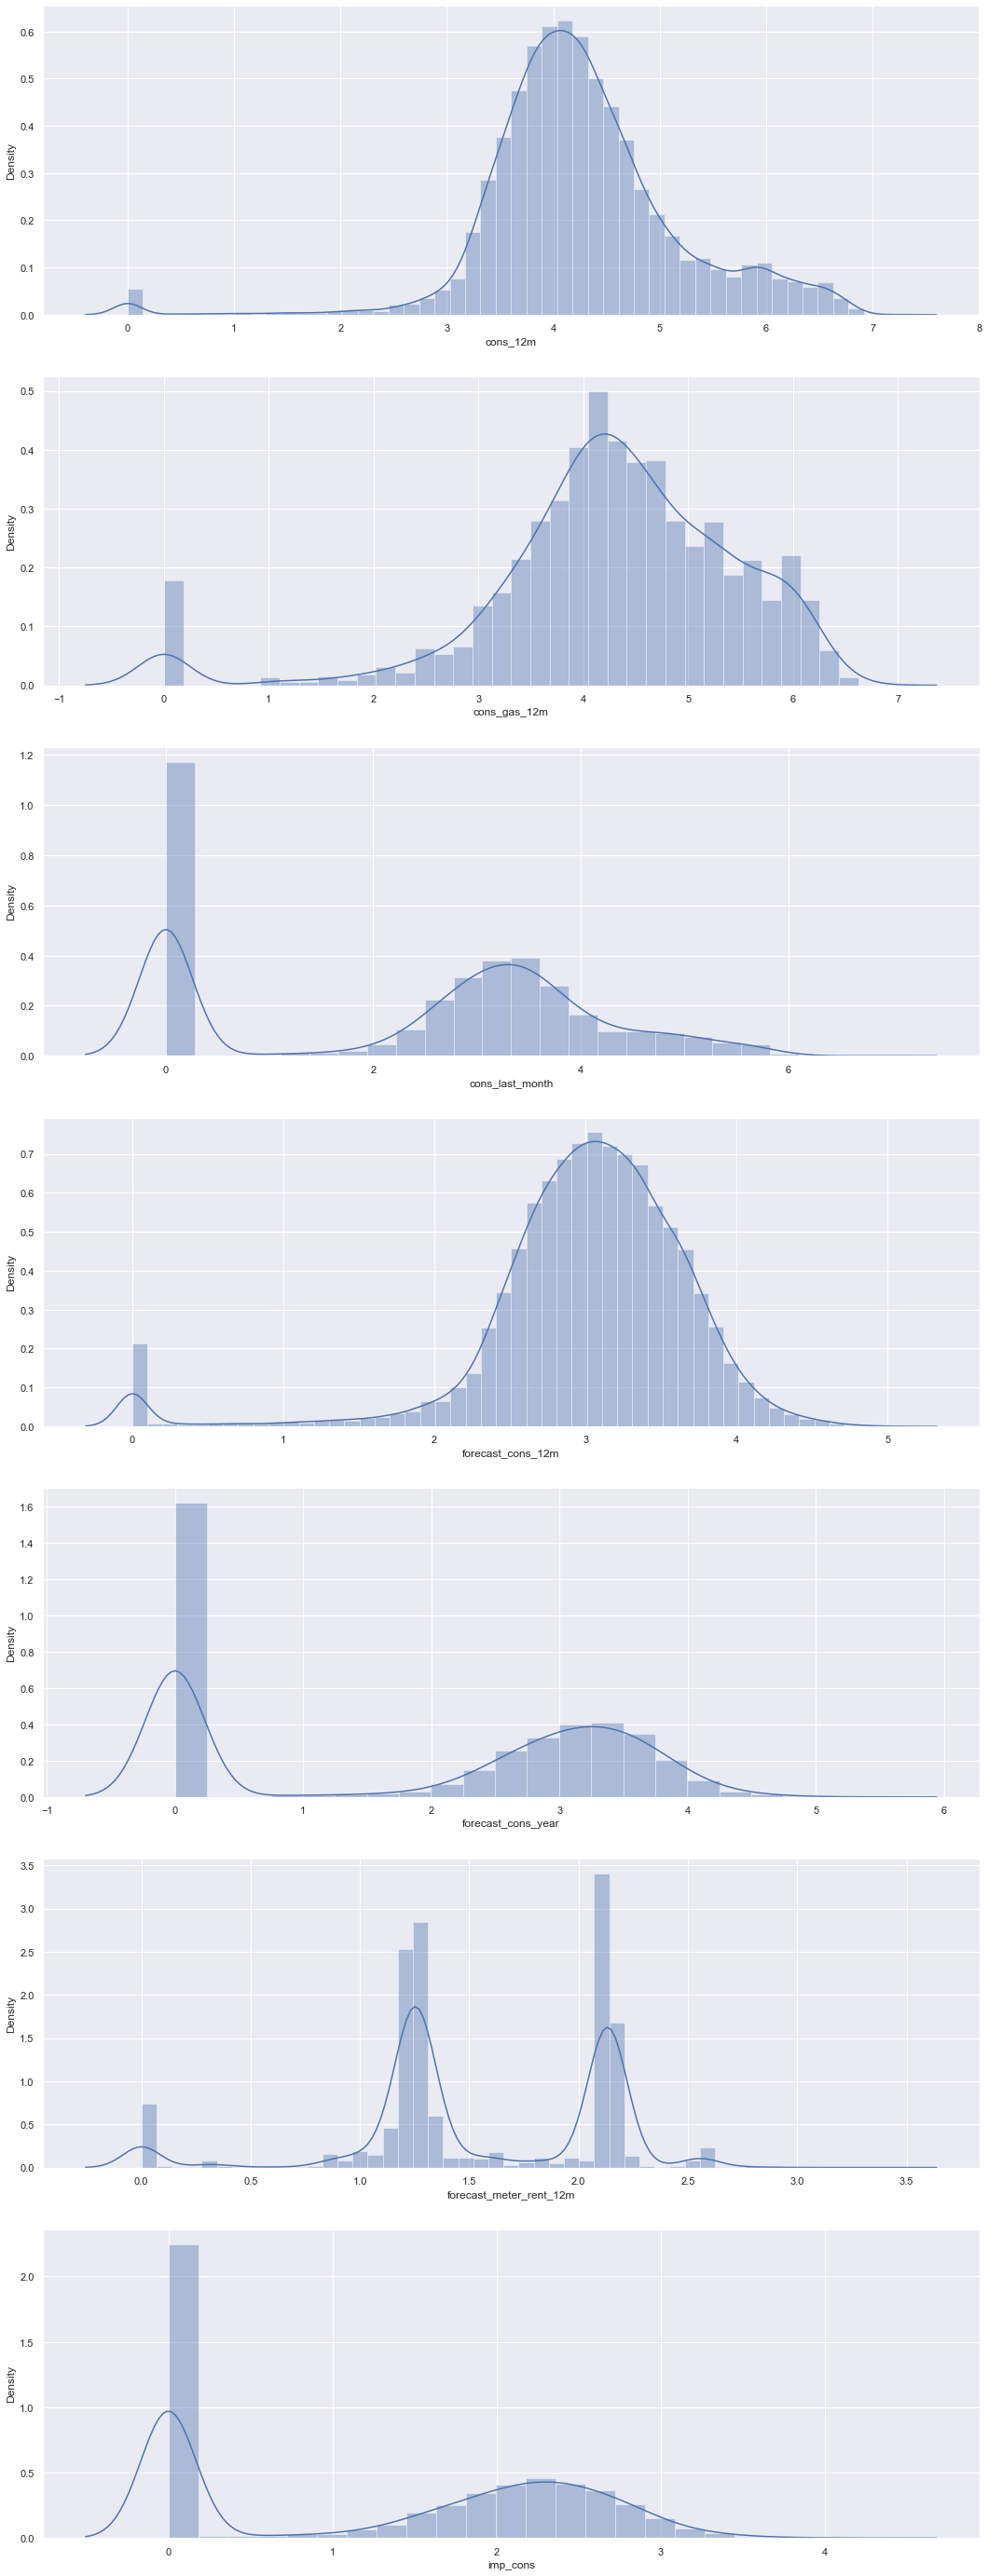

In [45]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot histograms
sns.distplot((train["cons_12m"].dropna()), ax=axs[0])
sns.distplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.distplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.distplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.distplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.distplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

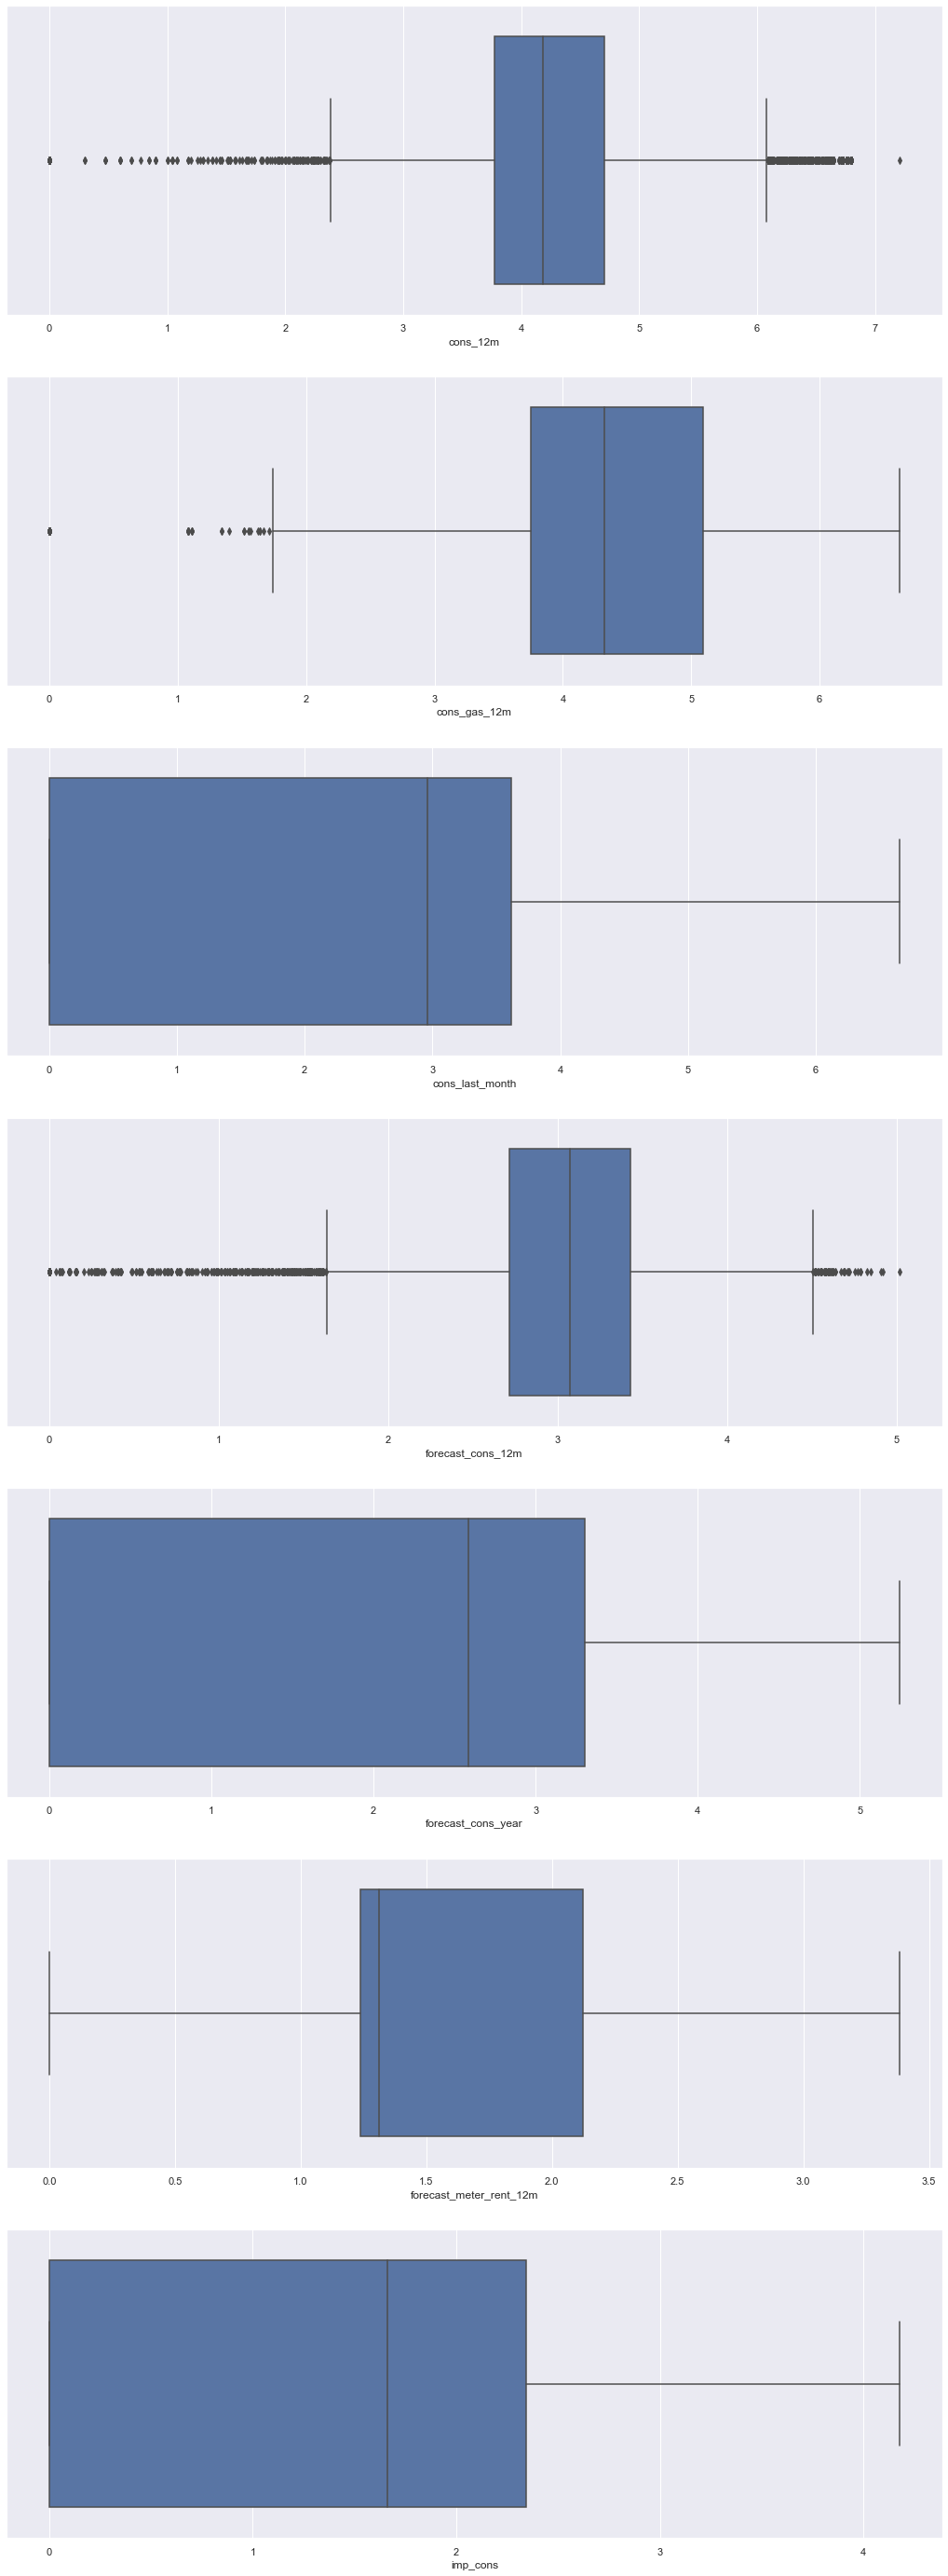

In [46]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

In [47]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_nul,activity_sfi,activity_wxe
count,16069.000000,16090.000000,16050.000000,16055.000000,16071.000000,15970.000000,16092.000000,15970.000000,15970.000000,15970.000000,16096.000000,16069.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,4.283812,0.800300,2.359281,3.006826,1.869956,0.991547,1.549610,0.135901,0.052951,43.533496,0.184145,1.305021,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,35.741240,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.808648,0.005157,0.007393
std,0.915265,1.748833,1.789067,0.709778,1.612963,5.160969,0.589394,0.026252,0.048617,5.212252,0.387615,1.165532,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,30.609746,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.393378,0.071626,0.085668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.122184,0.000000,0.000000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.773786,0.000000,0.000000,2.713952,0.000000,0.000000,1.236285,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,4.187408,0.000000,2.959041,3.073579,2.583199,0.000000,1.310481,0.142881,0.086163,44.311378,0.000000,1.662380,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,29.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,4.701508,0.000000,3.617000,3.430950,3.301030,0.000000,2.122126,0.146348,0.098837,44.311378,0.000000,2.341118,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,64.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,59.444710,1.000000,4.177357,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000,16.

## 3.0 High correlation variables

In [48]:
# Calculate correlation of variables
correlation = features.corr()

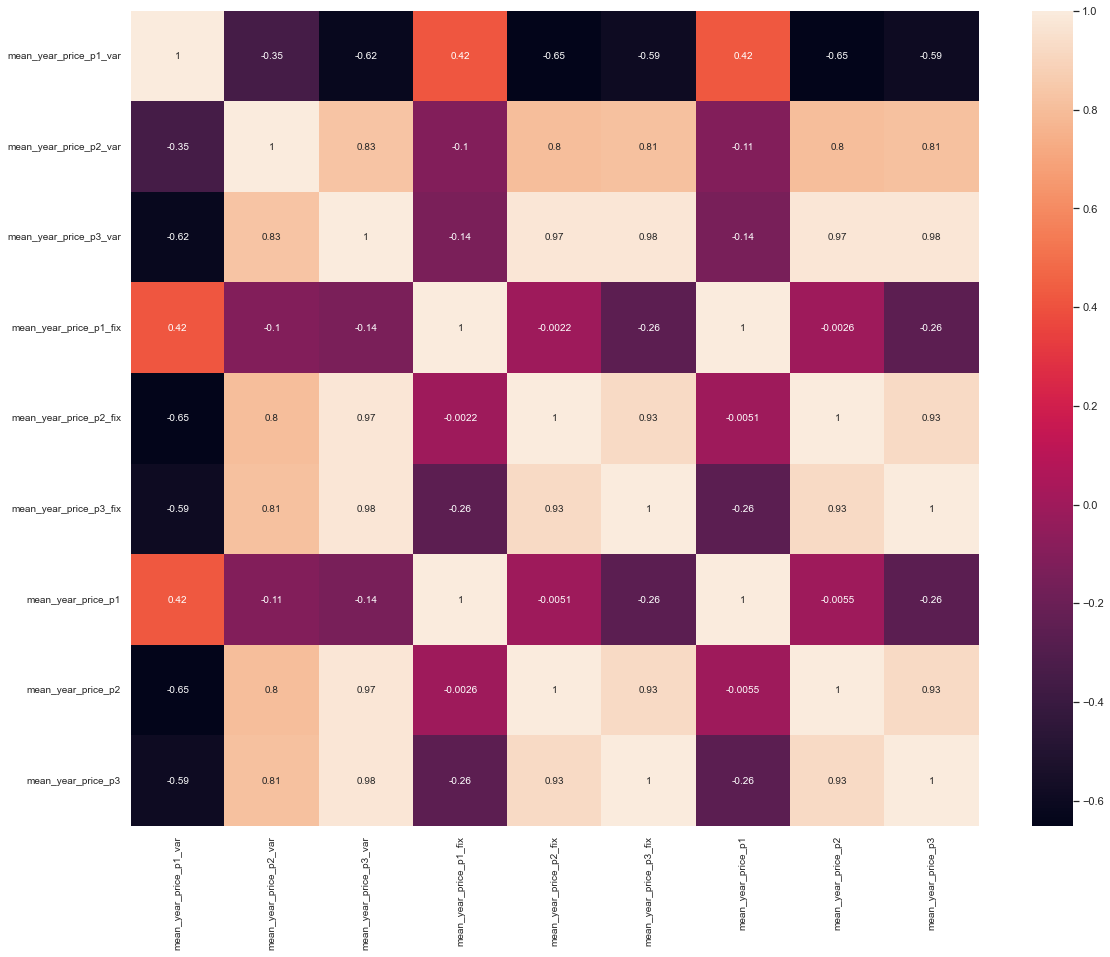

In [49]:
 # Plot correlation
plt.figure(figsize=(19,15))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
 yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [50]:
correlation = train.corr()

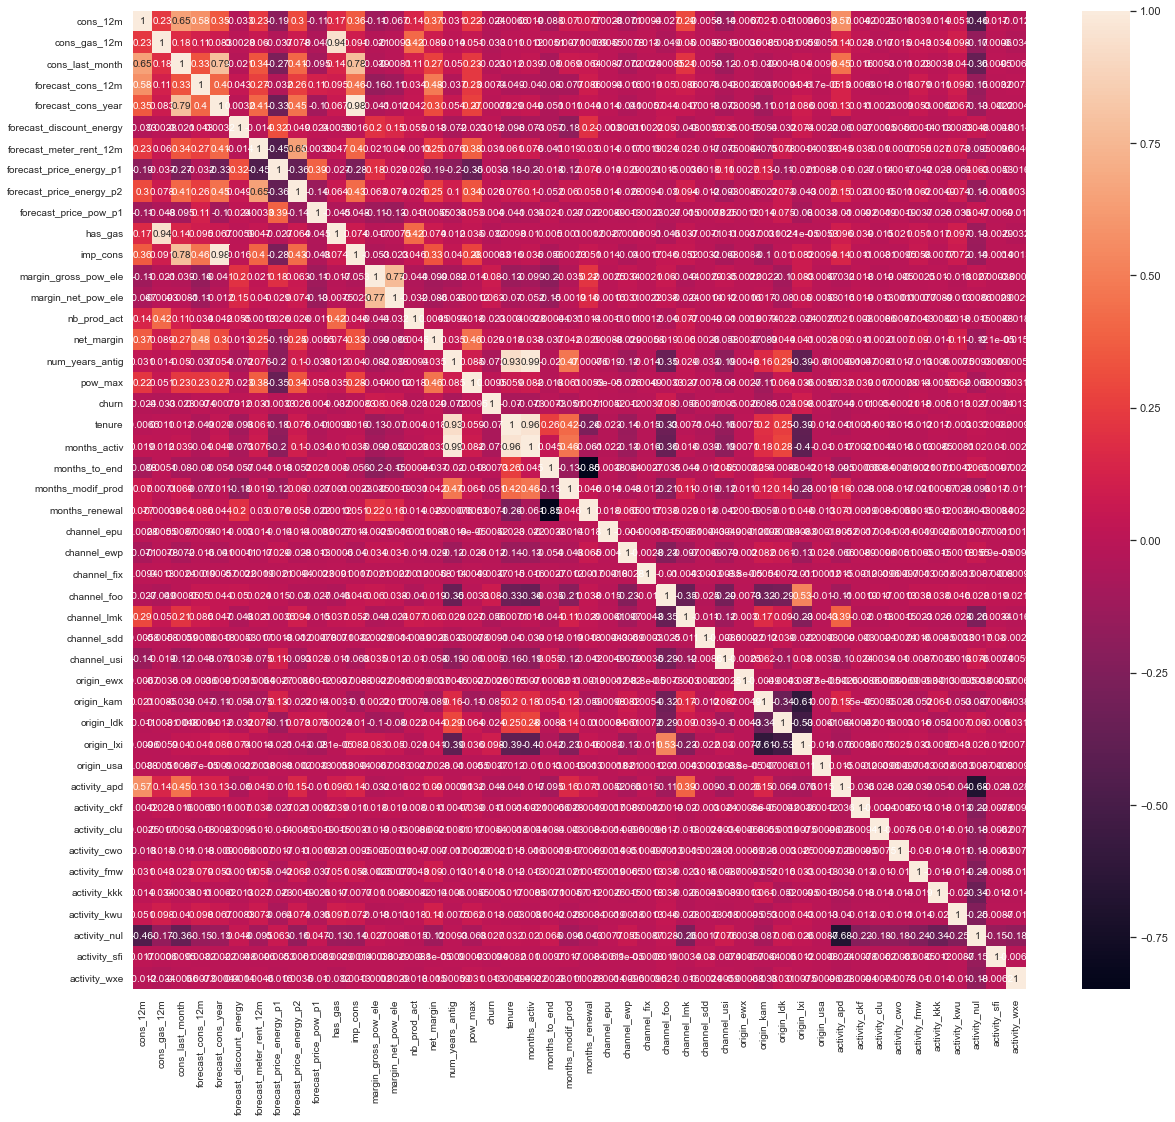

In [51]:
 # Plot correlation
plt.figure(figsize=(20,18))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
 yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [52]:
train.drop(columns=["num_years_antig", "forecast_cons_year"],inplace=True)

## 4.0 Removing outliers

In [53]:
def replace_outliers_z_score(dataframe, column, Z=3):
 """
 Replace outliers with the mean values using the Z score.
 Nan values are also replaced with the mean values.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """
 from scipy.stats import zscore

 df = dataframe.copy(deep=True)
 df.dropna(inplace=True, subset=[column])

 # Calculate mean without outliers
 df["zscore"] = zscore(df[column])
 mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()

 # Replace with mean values
 dataframe[column] = dataframe[column].fillna(mean_)
 dataframe["zscore"] = zscore(dataframe[column])
 no_outliers = dataframe[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z)].shape[0]
 dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_

 # Print message
 print("Replaced:", no_outliers, " outliers in ", column)
 return dataframe.drop(columns="zscore")

In [55]:
for c in features.columns:
 if c != "id":
     features = replace_outliers_z_score(features,c)

Replaced: 276  outliers in  mean_year_price_p1_var
Replaced: 0  outliers in  mean_year_price_p2_var
Replaced: 0  outliers in  mean_year_price_p3_var
Replaced: 120  outliers in  mean_year_price_p1_fix
Replaced: 0  outliers in  mean_year_price_p2_fix
Replaced: 0  outliers in  mean_year_price_p3_fix
Replaced: 122  outliers in  mean_year_price_p1
Replaced: 0  outliers in  mean_year_price_p2
Replaced: 0  outliers in  mean_year_price_p3


In [56]:
features.reset_index(drop=True, inplace=True)

In [58]:
def _find_outliers_iqr(dataframe, column):
 """
 Find outliers using the 1.5*IQR rule.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dict
 With the values of the iqr, lower_bound and upper_bound
 """
 col = sorted(dataframe[column])
 q1, q3= np.percentile(col,[25,75])
 iqr = q3 - q1
 lower_bound = q1 -(1.5 * iqr)
 upper_bound = q3 +(1.5 * iqr)
 results = {"iqr": iqr, "lower_bound":lower_bound, "upper_bound":upper_bound}
 return results
def remove_outliers_iqr(dataframe, column):
 """
 Remove outliers using the 1.5*IQR rule.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """

 outliers = _find_outliers_iqr(dataframe, column)
 removed = dataframe[(dataframe[column] < outliers["lower_bound"]) |
 (dataframe[column] > outliers["upper_bound"])].shape

 dataframe = dataframe[(dataframe[column] > outliers["lower_bound"]) &
 (dataframe[column] < outliers["upper_bound"])]
 print("Removed:", removed[0], " outliers")
 return dataframe
def remove_outliers_z_score(dataframe, column, Z=3):
 """
 Remove outliers using the Z score. Values with more than 3 are removed.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """
 from scipy.stats import zscore

 dataframe["zscore"] = zscore(dataframe[column])

 removed = dataframe[(dataframe["zscore"] < -Z) |
 (dataframe["zscore"] > Z)].shape

 dataframe = dataframe[(dataframe["zscore"] > -Z) &
 (dataframe["zscore"] < Z)]

 print("Removed:", removed[0], " outliers of ", column)

 return dataframe.drop(columns="zscore")

def replace_outliers_z_score(dataframe, column, Z=3):
 """
 Replace outliers with the mean values using the Z score.
 Nan values are also replaced with the mean values.
 Parameters
 ----------
 dataframe : pandas dataframe
 Contains the data where the outliers are to be found
 column : str
 Usually a string with the name of the column

 Returns
 -------
 Dataframe
 With outliers under the lower and above the upper bound removed
 """
 from scipy.stats import zscore

 df = dataframe.copy(deep=True)
 df.dropna(inplace=True, subset=[column])

 # Calculate mean without outliers
 df["zscore"] = zscore(df[column])
 mean_ = df[(df["zscore"] > -Z) & (df["zscore"] < Z)][column].mean()

 # Replace with mean values
 no_outliers = dataframe[column].isnull().sum()
 dataframe[column] = dataframe[column].fillna(mean_)
 dataframe["zscore"] = zscore(dataframe[column])
 dataframe.loc[(dataframe["zscore"] < -Z) | (dataframe["zscore"] > Z),column] = mean_

 # Print message
 print("Replaced:", no_outliers, " outliers in ", column)
 return dataframe.drop(columns="zscore")

In [59]:
train = replace_outliers_z_score(train,"cons_12m")
train = replace_outliers_z_score(train,"cons_gas_12m")
train = replace_outliers_z_score(train,"cons_last_month")
train = replace_outliers_z_score(train,"forecast_cons_12m")
#train = replace_outliers_z_score(train,"forecast_cons_year")
train = replace_outliers_z_score(train,"forecast_discount_energy")
train = replace_outliers_z_score(train,"forecast_meter_rent_12m")
train = replace_outliers_z_score(train,"forecast_price_energy_p1")
train = replace_outliers_z_score(train,"forecast_price_energy_p2")
train = replace_outliers_z_score(train,"forecast_price_pow_p1")
train = replace_outliers_z_score(train,"imp_cons")
train = replace_outliers_z_score(train,"margin_gross_pow_ele")
train = replace_outliers_z_score(train,"margin_net_pow_ele")
train = replace_outliers_z_score(train,"net_margin")
train = replace_outliers_z_score(train,"pow_max")
train = replace_outliers_z_score(train,"months_activ")
train = replace_outliers_z_score(train,"months_to_end")
train = replace_outliers_z_score(train,"months_modif_prod")
train = replace_outliers_z_score(train,"months_renewal")

Replaced: 27  outliers in  cons_12m
Replaced: 6  outliers in  cons_gas_12m
Replaced: 46  outliers in  cons_last_month
Replaced: 41  outliers in  forecast_cons_12m
Replaced: 126  outliers in  forecast_discount_energy
Replaced: 4  outliers in  forecast_meter_rent_12m
Replaced: 126  outliers in  forecast_price_energy_p1
Replaced: 126  outliers in  forecast_price_energy_p2
Replaced: 126  outliers in  forecast_price_pow_p1
Replaced: 27  outliers in  imp_cons
Replaced: 13  outliers in  margin_gross_pow_ele
Replaced: 13  outliers in  margin_net_pow_ele
Replaced: 15  outliers in  net_margin
Replaced: 3  outliers in  pow_max
Replaced: 0  outliers in  months_activ
Replaced: 0  outliers in  months_to_end
Replaced: 0  outliers in  months_modif_prod
Replaced: 0  outliers in  months_renewal


In [60]:
train.reset_index(drop=True, inplace=True)

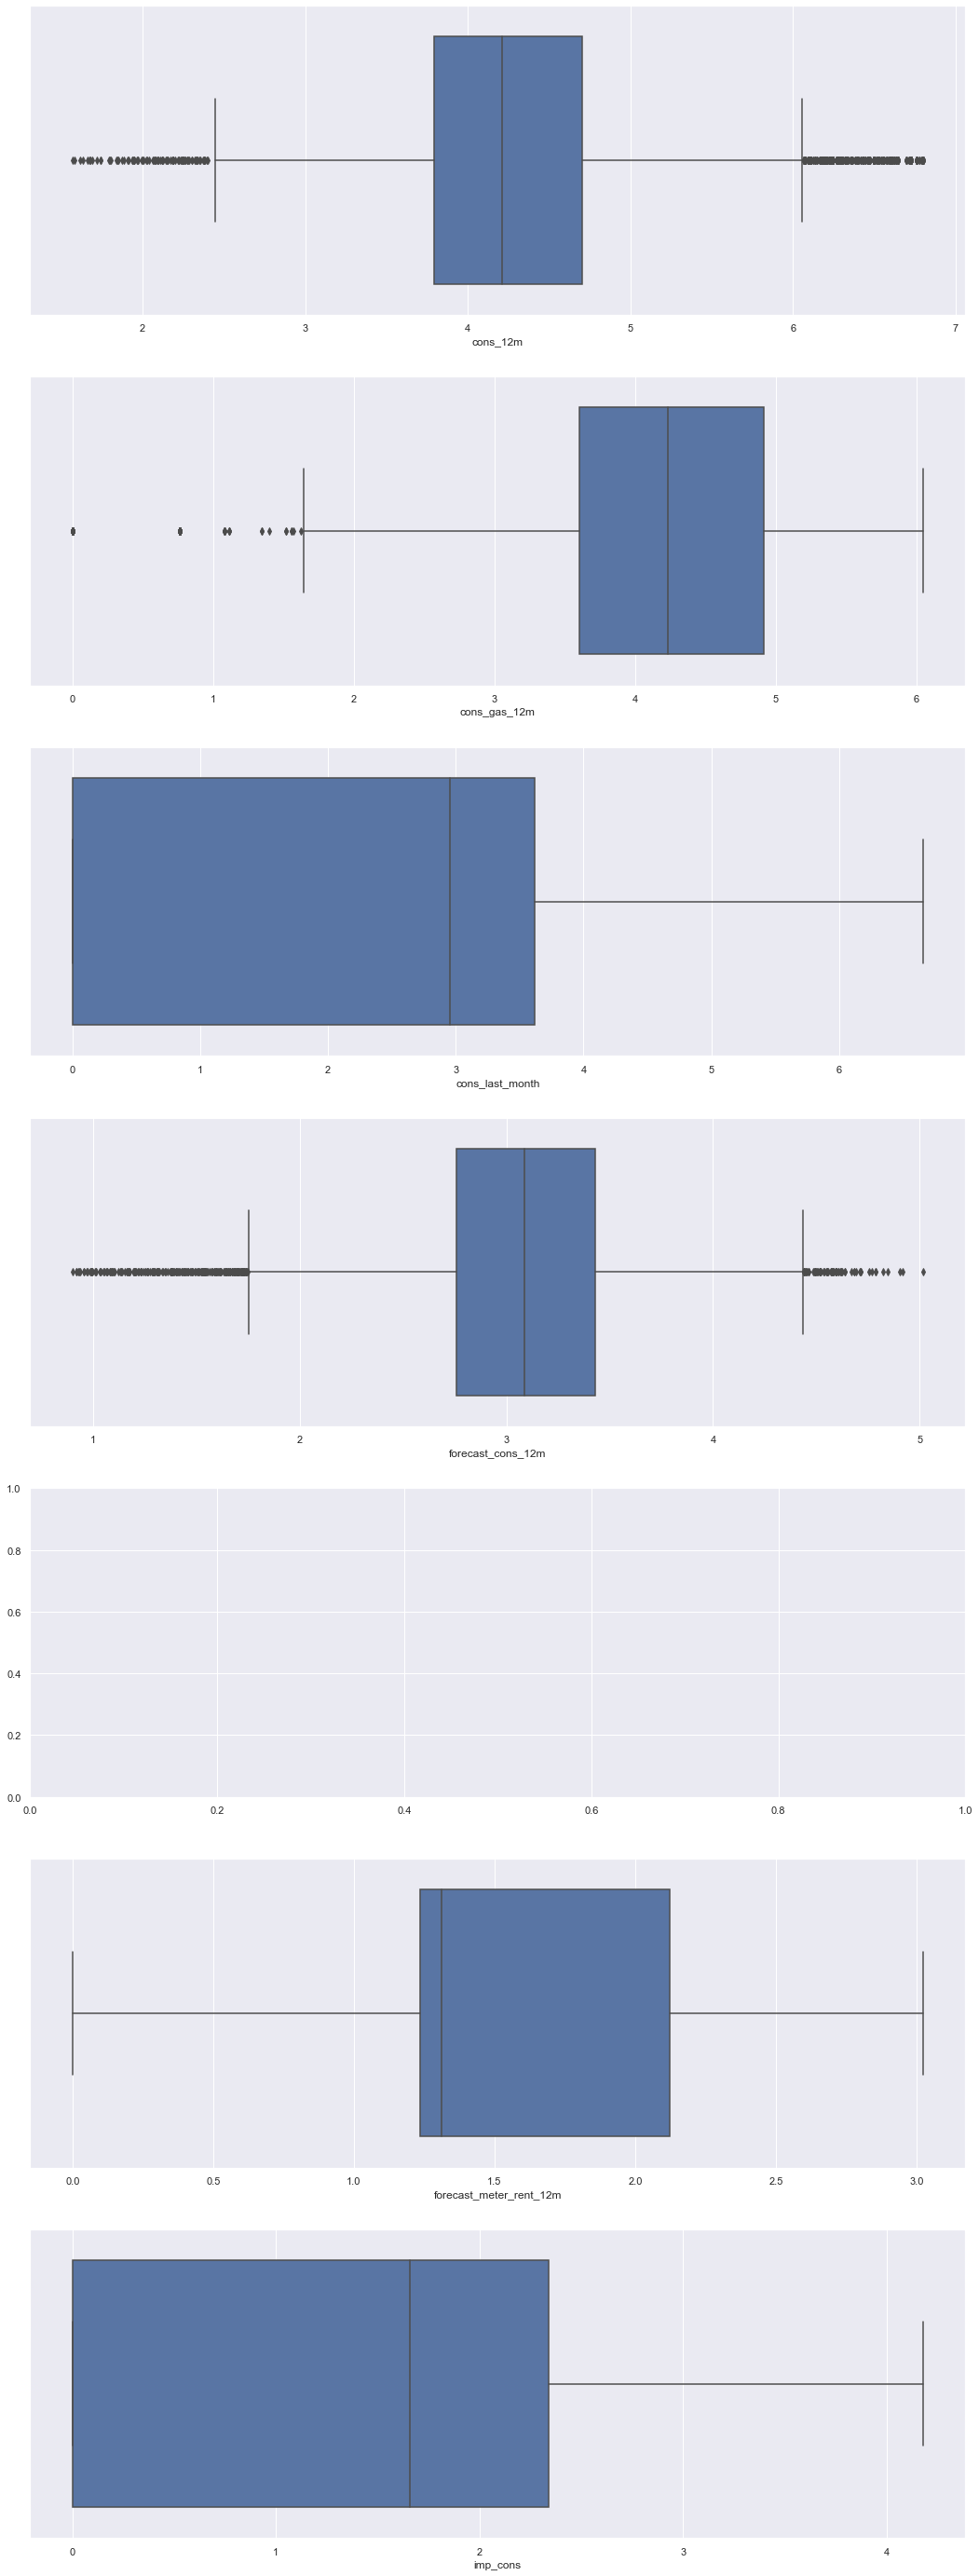

In [61]:
fig, axs = plt.subplots(nrows=7, figsize=(18,50))
# Plot boxplots
sns.boxplot((train["cons_12m"].dropna()), ax=axs[0])
sns.boxplot((train[train["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.boxplot((train["cons_last_month"].dropna()), ax=axs[2])
sns.boxplot((train["forecast_cons_12m"].dropna()), ax=axs[3])
#sns.boxplot((train["forecast_cons_year"].dropna()), ax=axs[4])
sns.boxplot((train["forecast_meter_rent_12m"].dropna()), ax=axs[5])
sns.boxplot((train["imp_cons"].dropna()), ax=axs[6])
plt.show()

## 5.0 Pickling

In [62]:
PICKLE_TRAIN_DIR = os.path.join("..", "processed_data", "train_data.pkl")
PICKLE_HISTORY_DIR = os.path.join("..", "processed_data", "history_data.pkl")

In [63]:
pd.to_pickle(train, PICKLE_TRAIN_DIR)
pd.to_pickle(history_data, PICKLE_HISTORY_DIR)